In [1]:
# Initial notebook by Xishui
#https://github.com/watertien/T3_offline_trigger/blob/main/offline_coincidence_check.ipynb
    
import numpy as np
import matplotlib.pyplot as plt
# import glob
from scipy.fft import rfftfreq, rfft, irfft
from grand import ECEF, Geodetic, GRANDCS, LTP
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit
import os 
import datetime
plt.style.use("/home/olivier/GRAND/soft/l3.mplstyle")

#data_dir = "/home/olivier/GRAND/data/GP300/gp13/xishui_data/aug2024/"
data_dir = "/home/olivier/GRAND/data/GP300/gp13/xishui_data/"

Welcome to JupyROOT 6.26/10


# Use one file as an example

## Zenith distribution

In [1]:
rec_PWF = np.genfromtxt(data_dir+"GP13_20240616_122342_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_001.root/Rec_plane_wave_recons.txt")

zenith_wrapped_around_horizon = rec_PWF[:,2].copy()
zenith_wrapped_around_horizon = 180 - zenith_wrapped_around_horizon
zenith_wrapped_around_horizon[zenith_wrapped_around_horizon > 90] = 90 - (zenith_wrapped_around_horizon[zenith_wrapped_around_horizon > 90] - 90)
# plt.hist(zenith_wrapped_around_horizon, bins=np.linspace(70, 90, 201), label='Total', histtype='step', lw=3, color='k')
for ndu in np.unique(rec_PWF[:,1]):
    plt.hist(zenith_wrapped_around_horizon[rec_PWF[:,1] == ndu], bins=np.linspace(0, 90, 91), label='n$_{DU}=$' + f'{ndu}', histtype='step', lw=1)
# plt.hist(zenith_wrapped_around_horizon[rec_PWF[:,1] == 5], bins=np.linspace(0, 90, 91), label='n$_{DU}=5$', histtype='step', lw=1)
# plt.hist(zenith_wrapped_around_horizon[rec_PWF[:,1] == 6], bins=np.linspace(0, 90, 91), label='n$_{DU}=6$', histtype='step', lw=1)
# plt.hist(zenith_wrapped_around_horizon[rec_PWF[:,1] == 7], bins=np.linspace(0, 90, 91), label='n$_{DU}=7$', histtype='step', lw=1)

plt.legend()
plt.xlabel('Zenith [deg] (wrapped at the horizon)')
plt.grid()
# plt.xlim(70, 90)
# plt.xticks(np.arange(0, 91, 10))
plt.tight_layout()
plt.legend(loc='best')
# plt.savefig("imgs/zenith_dist_beacon_173.pdf");

NameError: name 'np' is not defined

## Azimuth distribution

In [ ]:
# change the coordinate system: "from source to observer" to "from observer to source"
# the conventional CR notation
azimuth = rec_PWF[:,4] + 180
azimuth[azimuth > 360] = azimuth[azimuth > 360] - 360
plt.hist(azimuth, bins=np.linspace(26, 28, 101), label='Total', histtype='step', lw=3, color='k')
for ndu in np.unique(rec_PWF[:,1]):
    plt.hist(azimuth[rec_PWF[:,1] == ndu], bins=np.linspace(0, 360, 181), label='n$_{DU}=$' + f'{ndu}', histtype='step', lw=1)
# plt.hist(azimuth[rec_PWF[:,1] == 4], bins=np.linspace(0, 360, 181), label='n$_{DU}=4$', histtype='step', lw=2)
# plt.hist(azimuth[rec_PWF[:,1] == 5], bins=np.linspace(0, 360, 181), label='n$_{DU}=5$', histtype='step', lw=2)
# plt.hist(azimuth[rec_PWF[:,1] == 6], bins=np.linspace(0, 360, 181), label='n$_{DU}=6$', histtype='step', lw=2)
# plt.hist(azimuth[rec_PWF[:,1] == 7], bins=np.linspace(0, 360, 181), label='n$_{DU}=7$', histtype='step', lw=2)
plt.legend()
plt.xlabel("Azimuth [deg]")
# plt.xlim(26, 28)
plt.grid()
plt.tight_layout()
# plt.savefig("imgs/azimuth_dist_beacon_173.pdf")

## Ploar plot on the reconstructed directions

In [ ]:
plt.polar(azimuth * np.pi / 180, zenith_wrapped_around_horizon, marker='.', ls='', markersize=8)
plt.gca().set_theta_zero_location('N', offset=0)

## Reconstructed source positions

In [ ]:
file_coinctable = np.genfromtxt(data_dir+"GP13_20240616_122342_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_001.root/Rec_coinctable.txt", dtype=float)
file_ducoord = np.genfromtxt(data_dir+"GP13_20240616_122342_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_001.root/coord_antennas.txt", dtype=float)
file_rec_sphere = np.genfromtxt(data_dir+"GP13_20240616_122342_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_001.root/Rec_sphere_wave_recons.txt", dtype=float, usecols=np.arange(9))
file_rec_plane = np.genfromtxt(data_dir+"GP13_20240616_122342_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_001.root/Rec_plane_wave_recons.txt", dtype=float)
file_du_id = np.genfromtxt(data_dir+"GP13_20240616_122342_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_001.root/DU_id.txt")

In [ ]:
plt.plot(-file_rec_sphere[:,5], file_rec_sphere[:,4], marker='.', ls='')

## Delay plots (sphere)

In [ ]:
list_chi2_sphere = []
for event_id in rec_PWF[:,0][rec_PWF[:,1] == 5]:
# event_id = [1] # the time of trace
  list_linenumber = file_coinctable[file_coinctable[:,1] == event_id,0]
  time_delay_exp = file_coinctable[file_coinctable[:,1] == event_id][:,2]
  mask_sort_time_delay = np.argsort(time_delay_exp)
  rec_pos_source = file_rec_sphere[file_rec_sphere[:,0] == event_id,4:7].flatten() # Reconstructed position of the source
  time_offset = file_rec_sphere[file_rec_sphere[:,0] == event_id,7] / 3e8 * 1e9
  du_pos = file_ducoord[list_linenumber.astype("int"),1:]
  time_delay_rec = np.sqrt(np.sum((du_pos - rec_pos_source)**2, axis=1)) / 3e8 * 1e9 # in nanoseconds
  plt.clf()
  plt.plot(time_delay_exp[mask_sort_time_delay] * 1e9, time_delay_rec[mask_sort_time_delay], marker='.', ls='')
  plt.plot([0, 2000], [0, 2000], ls='--', color='r')
  plt.xlabel(r"$\Delta t_{\rm exp} $ [ns]")
  plt.ylabel(r"$\Delta t_{\rm rec} $ [ns]")
  plt.title(f"Spherical Wave Rec {event_id:.0f}")
  plt.grid(True)
  plt.tight_layout()
  # plt.savefig(f"imgs/delay_spherical_{event_id}_5DU.pdf")

## Deplay plots (plane)

In [ ]:
list_chi2 = np.zeros(len(rec_PWF))
for i, event_id in enumerate(file_rec_plane[:,0]):
  list_linenumber = file_coinctable[file_coinctable[:,1] == event_id,0]
  time_delay_exp = file_coinctable[file_coinctable[:,1] == event_id,2]
  time_delay_exp_ns = time_delay_exp * 1e9
  time_delay_exp_ns0 = time_delay_exp_ns - time_delay_exp_ns.min()
  argmin = np.argmin(time_delay_exp_ns0)
  mask_sort_time_delay = np.argsort(time_delay_exp_ns0)

  rec_theta, rec_phi = np.radians(file_rec_plane[file_rec_plane[:,0] == event_id,[2,4]]) # Reconstructed direction of the source
  du_pos = file_ducoord[list_linenumber.astype("int"),1:]
  event_coord_shower_axis = np.dot(du_pos, [np.sin(rec_theta) * np.cos(rec_phi), np.sin(rec_theta) * np.sin(rec_phi), np.cos(rec_theta)]) 
  time_delay_rec =  event_coord_shower_axis / 3e8 * 1e9 # in nanoseconds
  # use the first triggered DU as the time origin
  time_offset = time_delay_exp_ns0[mask_sort_time_delay][0] - time_delay_rec[mask_sort_time_delay][argmin]
  chi2 = np.sum((time_delay_exp_ns0[mask_sort_time_delay] - (time_delay_rec[mask_sort_time_delay] + time_offset))**2) / (len(time_delay_exp) - 2)
  list_chi2[i] = chi2
  plt.clf()  
  plt.plot(time_delay_exp_ns0[mask_sort_time_delay], time_delay_rec[mask_sort_time_delay] + time_offset, marker='.', ls='')
  # plt.axis("equal")
  plt.plot(np.array([0, 6000]), np.array([0, 6000]), ls='--', color='r')
  plt.xlabel(r"$\Delta t_{\rm exp} $ [ns]")
  plt.ylabel(r"$\Delta t_{\rm rec} $ [ns]")
  plt.title(f"Plane Wave Rec {event_id:.0f}")
  plt.grid(True)
  plt.tight_layout()
  plt.savefig(f"imgs/0616/delay_plane_{event_id:.0f}.pdf")

## chi2 distribution

In [ ]:
plt.hist(list_chi2, np.logspace(-2, 10, 30))
plt.ylabel("# of events")
plt.xlabel("$\chi^2$")
plt.grid()
plt.loglog()

# Full set reconstruction

In [2]:
_dirlist = filter(os.path.isdir, [os.path.join(data_dir, f) for f in os.listdir(data_dir)])
dirlist1 = list(_dirlist)
dirlist1.sort()
dirlist = np.array(dirlist1)
# dirlist = [f for f in dirlist1 if "20240616" in f]

list_rec_plane = np.zeros((0,8), dtype=np.float64)
list_rec_sphere = np.zeros((0,10), dtype=np.float64)
list_coin_table = np.zeros((0,4), dtype=np.float64)
list_DU_coord = np.zeros((0,4), dtype=np.float64)
list_event_sec0 = np.zeros((0,1), dtype=np.int64)
list_event_nanos0 = np.zeros((0,1), dtype=np.int64)
list_event_t = np.zeros((0,1), dtype=np.float64)
list_peak = np.zeros((0,1), dtype=np.int32)
list_event_id = np.zeros((0,1), dtype=np.int64)
list_rec_id = np.zeros((0,1), dtype=np.int64)
list_DU_id = np.zeros((0,1), dtype=np.int16)
list_if_file = np.zeros(len(dirlist), dtype=bool)
no_swf = []
no_pwf = []
dur = 0
event_i = 0
for i, dir in enumerate(dirlist):
    if not os.path.exists(dir +'/Rec_coinctable.txt'):
      # Empty, skip
      continue
    if not os.path.exists(dir +'/DU_id.txt'):
      # Empty, skip
      continue
    size = os.path.getsize(dir +'/Rec_coinctable.txt')
    if size == 0:
      # Empty, skip
      continue
    print("Now ",dir)    
    if os.path.isfile(dir+'/Rec_plane_wave_recons.txt') == False:
      no_pwf.append(dir)
      continue
    if os.path.isfile(dir+'/Rec_sphere_wave_recons.txt') == False:
      no_swf.append(dir)
      continue
    _list_coin_table = np.genfromtxt(dir +'/Rec_coinctable.txt', dtype=np.float64)
    if len((np.unique(_list_coin_table[:,1])))< 2:  # Skip file if ony one coinc
       continue
    list_if_file[i] = 1
    list_DU_id = np.append(list_DU_id, np.genfromtxt(dir +'/DU_id.txt', usecols=0, dtype=np.int16))
    list_event_sec0 = np.append(list_event_sec0, np.genfromtxt(dir +'/DU_id.txt', usecols=1, dtype=np.int64))
    list_event_nanos0 = np.append(list_event_nanos0, np.genfromtxt(dir +'/DU_id.txt', usecols=2, dtype=np.int64))
    list_coin_table = np.append(list_coin_table, _list_coin_table, axis=0)
    dur += _list_coin_table[2,-1]
    list_DU_coord = np.append(list_DU_coord, np.genfromtxt(dir +'/coord_antennas.txt', dtype=np.float64), axis=0)
    # print(dir)
    _list_rec_plane = np.genfromtxt(dir +'/Rec_plane_wave_recons.txt', dtype=np.float64).reshape((-1, 8))
    list_rec_plane = np.append(list_rec_plane, _list_rec_plane, axis=0)
    _list_rec_sphere = np.genfromtxt(dir +'/Rec_sphere_wave_recons.txt', usecols=np.arange(10), dtype=np.float64).reshape((-1, 10))
    list_rec_sphere = np.append(list_rec_sphere, _list_rec_sphere, axis=0)
    if len(_list_rec_sphere) != len(_list_rec_plane):
        print("Error!",dir, len(_list_rec_sphere), len(_list_rec_plane))
        break
    # Book keeping of unique IDs for events & coincs   
    _list_event_i =  _list_coin_table[:,1]
    _list_rec_i = _list_rec_plane[:,0]
    list_event_id = np.append(list_event_id, _list_event_i + event_i)
    list_rec_id = np.append(list_rec_id, _list_rec_i + event_i)
    event_i += _list_event_i[-1] + 1 # ID starts from 0
    print("Now",len(list_event_id),"events and",len(list_rec_id),"reconstructed coincs in",dur/3600,"hours." )
    # if (_list_event_i[-1]) != len(_list_rec_plane):
    #if (_list_event_i[-1] + 1) != len(_list_rec_plane):
    #    print(dir, _list_event_i[-1] + 1, len(_list_rec_plane))
    # break
    # _, _ndu = np.unique(_list_event_i, return_counts=True)

print("Missing PWF recons file for dirs",no_pwf)
print("Missing SWF recons file for dirs",no_swf)


Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240625_065436_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_010.root
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240625_075858_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_013.root
Now 96 events and 12 reconstructed coincs in 0.075 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240625_082352_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_014.root
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240625_085819_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_015.root
Now 222 events and 17 reconstructed coincs in 0.11138888888888888 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240625_091227_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_016.root
Now 235 events and 18 reconstructed coincs in 0.15555555555555556 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240625_102105_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_018.root
Now 281 events and 19 reconstructed coincs in 0.1986111111111111 hours.
Now  /home/olivier/GRAND/dat

Now 28129 events and 2159 reconstructed coincs in 2.3088888888888888 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240702_185834_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_006.root
Now 29269 events and 2255 reconstructed coincs in 2.347777777777778 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240702_190149_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_007.root
Now 30189 events and 2351 reconstructed coincs in 2.3891666666666667 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240702_190356_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_008.root
Now 30978 events and 2420 reconstructed coincs in 2.4338888888888888 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240702_192515_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_009.root
Now 31971 events and 2515 reconstructed coincs in 2.466666666666667 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240702_200942_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_010.root
Now 32833 events and 2595 reconstructed coincs 

Now 65757 events and 6029 reconstructed coincs in 4.6466666666666665 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240703_061623_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_055.root
Now 66081 events and 6042 reconstructed coincs in 4.683055555555556 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240703_065847_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_058.root
Now 66096 events and 6042 reconstructed coincs in 4.7363888888888885 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240703_165730_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_001.root


/tmp/ipykernel_6412/789074515.py:52: UserWarning: genfromtxt: Empty input file: "/home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240703_065847_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_058.root/Rec_plane_wave_recons.txt"
  _list_rec_plane = np.genfromtxt(dir +'/Rec_plane_wave_recons.txt', dtype=np.float64).reshape((-1, 8))
/tmp/ipykernel_6412/789074515.py:54: UserWarning: genfromtxt: Empty input file: "/home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240703_065847_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_058.root/Rec_sphere_wave_recons.txt"
  _list_rec_sphere = np.genfromtxt(dir +'/Rec_sphere_wave_recons.txt', usecols=np.arange(10), dtype=np.float64).reshape((-1, 10))


Now 66760 events and 6086 reconstructed coincs in 4.788611111111111 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240703_180835_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_002.root
Now 67419 events and 6135 reconstructed coincs in 4.8469444444444445 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240703_214754_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_003.root
Now 68227 events and 6198 reconstructed coincs in 4.898611111111111 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240703_215112_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_004.root
Now 69026 events and 6261 reconstructed coincs in 4.9447222222222225 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240703_215438_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_005.root
Now 69785 events and 6310 reconstructed coincs in 5.0313888888888885 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240703_215750_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_006.root
Now 70510 events and 6366 reconstructed coincs 

Now 96061 events and 8540 reconstructed coincs in 7.0505555555555555 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240705_093500_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_018.root
Now 96745 events and 8605 reconstructed coincs in 7.086111111111111 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240705_093900_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_019.root
Now 97650 events and 8704 reconstructed coincs in 7.118333333333333 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240705_094952_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_020.root
Now 98543 events and 8785 reconstructed coincs in 7.200833333333334 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240705_095655_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_021.root
Now 99178 events and 8828 reconstructed coincs in 7.241388888888889 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240705_100049_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_022.root
Now 99934 events and 8902 reconstructed coincs in

/tmp/ipykernel_6412/789074515.py:52: UserWarning: genfromtxt: Empty input file: "/home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240706_040726_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_034.root/Rec_plane_wave_recons.txt"
  _list_rec_plane = np.genfromtxt(dir +'/Rec_plane_wave_recons.txt', dtype=np.float64).reshape((-1, 8))
/tmp/ipykernel_6412/789074515.py:54: UserWarning: genfromtxt: Empty input file: "/home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240706_040726_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_034.root/Rec_sphere_wave_recons.txt"
  _list_rec_sphere = np.genfromtxt(dir +'/Rec_sphere_wave_recons.txt', usecols=np.arange(10), dtype=np.float64).reshape((-1, 10))


Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240706_043512_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_085.root
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240706_043520_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_086.root
Now 115917 events and 10479 reconstructed coincs in 8.370555555555555 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240706_124346_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_088.root
Now 116007 events and 10479 reconstructed coincs in 8.453611111111112 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240706_141310_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_089.root


/tmp/ipykernel_6412/789074515.py:52: UserWarning: genfromtxt: Empty input file: "/home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240706_124346_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_088.root/Rec_plane_wave_recons.txt"
  _list_rec_plane = np.genfromtxt(dir +'/Rec_plane_wave_recons.txt', dtype=np.float64).reshape((-1, 8))
/tmp/ipykernel_6412/789074515.py:54: UserWarning: genfromtxt: Empty input file: "/home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240706_124346_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_088.root/Rec_sphere_wave_recons.txt"
  _list_rec_sphere = np.genfromtxt(dir +'/Rec_sphere_wave_recons.txt', usecols=np.arange(10), dtype=np.float64).reshape((-1, 10))
/tmp/ipykernel_6412/789074515.py:52: UserWarning: genfromtxt: Empty input file: "/home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240706_141310_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_089.root/Rec_plane_wave_recons.txt"
  _list_rec_plane = np.genfromtxt(dir +'/Rec_plane_wave_recons.txt', dtype=np.float64).reshape((-1, 8))
/tmp/ip

Now 116103 events and 10479 reconstructed coincs in 8.503333333333334 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240706_162207_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_090.root
Now 116118 events and 10479 reconstructed coincs in 8.549166666666666 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240706_184017_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_002.root
Now 116887 events and 10542 reconstructed coincs in 8.590555555555556 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240706_194332_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_003.root
Now 118006 events and 10658 reconstructed coincs in 8.645555555555555 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240706_195655_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_004.root
Now 119016 events and 10729 reconstructed coincs in 8.691666666666666 hours.
Now  /home/olivier/GRAND/data/GP300/gp13/xishui_data/GP13_20240706_205125_RUN127_UD_RAW_ChanXYZ_20dB_9DUs_005.root
Now 119882 events and 10818 reconstructe

123301 events, 36015 coincs and 11137 reconstructed coincs (mult>3).


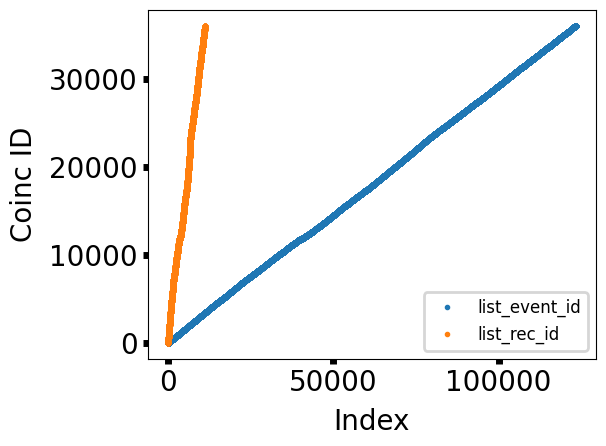

123301


In [3]:
# Clean up tables
list_event_t_true = (list_coin_table[:,2] * 1e9).astype(np.int64) + list_event_nanos0 + list_event_sec0 * 1e9
plt.plot(list_event_id,'.',label='list_event_id')
plt.plot(list_rec_id,'.',label='list_rec_id')
plt.legend(loc='best')
plt.xlabel('Index')
plt.ylabel('Coinc ID')
print(len(list_event_id),"events,",int(max(list_event_id)),"coincs and",len(list_rec_id),"reconstructed coincs (mult>3)." )
plt.show()
print(len(list_coin_table))

## Chi2

In [4]:
list_chi2 = np.zeros(len(list_rec_id))
list_chi2_swf = np.zeros(len(list_rec_id))
do_plot = 0
for i, event_id in enumerate(list_rec_id):
  if int(i/100) == i/100:
    print(i,"/",len(list_rec_id),"...")
  # Select proper lines both in coinc and recons files 
  mask_event = list_event_id == event_id
  #ind_rec = list_rec_id == event_id
  #list_linenumber = list_coin_table[mask_event,0]
  if (i>1) & (sum(mask_event)<4):
    print("Error! Should not be here")
    print(i,event_id,list_coin_table[mask_event,1:3])
    break
  time_delay_exp = list_coin_table[mask_event,2]
  time_delay_exp_ns = time_delay_exp * 1e9
  time_delay_exp_ns0 = time_delay_exp_ns - time_delay_exp_ns.min()
  argmin = np.argmin(time_delay_exp_ns0)
  mask_sort_time_delay = np.argsort(time_delay_exp_ns0)
  
  # PWF 
  rec_theta, rec_phi = np.radians(list_rec_plane[i,[2,4]]) # Reconstructed direction of the source
  du_pos = list_DU_coord[mask_event,1:]
  du_id = list_DU_id[mask_event]
  event_coord_shower_axis = np.dot(du_pos, [np.sin(rec_theta) * np.cos(rec_phi), np.sin(rec_theta) * np.sin(rec_phi), np.cos(rec_theta)]) 
  time_delay_rec =  event_coord_shower_axis / 3e8 * 1e9 # in nanoseconds
  # use the first triggered DU as the time origin
  time_offset = time_delay_exp_ns0[mask_sort_time_delay][0] - time_delay_rec[mask_sort_time_delay][argmin]
  chi2 = np.sum((time_delay_exp_ns0[mask_sort_time_delay] - (time_delay_rec[mask_sort_time_delay] + time_offset))**2) / (len(time_delay_exp) - 2) / 10**2  
  if chi2 == np.nan:
      print(i, event_id)
      break 
  list_chi2[i] = chi2

  # SWF
  source_pos = list_rec_sphere[i,4:7]
  time_delay_sph  = np.linalg.norm(du_pos-source_pos,axis=1)/ 3e8 * 1e9 # in nanoseconds
  # use the first triggered DU as the time origin
  time_offset_sph = time_delay_exp_ns0[mask_sort_time_delay][0] - time_delay_sph[mask_sort_time_delay][argmin]
  chi2sph = np.sum((time_delay_exp_ns0[mask_sort_time_delay] - (time_delay_sph[mask_sort_time_delay] + time_offset_sph))**2) / (len(time_delay_exp) - 3) / 10**2  
  if chi2 == np.nan:
      print(i, event_id)
      break 
  list_chi2_swf[i] = chi2sph
  if do_plot == 1:
    plt.clf()  
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(time_delay_exp_ns0[mask_sort_time_delay], time_delay_rec[mask_sort_time_delay] + time_offset, marker='o', ls='')
    # plt.axis("equal")
    plt.plot(np.array([0, max(time_delay_exp_ns0)*1.1]), np.array([0, max(time_delay_exp_ns0)*1.1]), ls='--', color='r')
    plt.xlabel(r"$\Delta t_{\rm exp} $ [ns]")
    plt.ylabel(r"$\Delta t_{\rm rec} $ [ns]")
    plt.title(f"Plane Wave Rec {event_id:.0f}")
    for j in range(len(time_delay_exp)):
        plt.text(time_delay_exp_ns0[mask_sort_time_delay[j]]+200, time_delay_rec[mask_sort_time_delay[j]] + time_offset,du_id[j],fontsize=12)
    plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(time_delay_exp_ns0[mask_sort_time_delay], time_delay_sph[mask_sort_time_delay] + time_offset_sph, marker='o', ls='')
    # plt.axis("equal")
    plt.plot(np.array([0, max(time_delay_exp_ns0)*1.1]), np.array([0, max(time_delay_exp_ns0)*1.1]), ls='--', color='r')
    plt.xlabel(r"$\Delta t_{\rm exp} $ [ns]")
    plt.ylabel(r"$\Delta t_{\rm rec} $ [ns]")
    plt.title(f"Spherical Wave Rec {event_id:.0f}")
    for j in range(len(time_delay_exp)):
        plt.text(time_delay_exp_ns0[mask_sort_time_delay[j]]+200, time_delay_sph[mask_sort_time_delay[j]] + time_offset_sph,du_id[j],fontsize=12)
    plt.grid(True)
    plt.tight_layout()   
    plt.show();
    print("Event",int(event_id))
    print("Chi2 plan = ",chi2,"(theta,phi)=",list_rec_plane[i,[2,4]])
    print("Chi2 sph = ",chi2sph,"(x,y,z)=",source_pos)
#    plt.savefig(f"imgs/0616/delay_plane_{event_id:.0f}.pdf")

0 / 11137 ...
100 / 11137 ...
200 / 11137 ...
300 / 11137 ...
400 / 11137 ...
500 / 11137 ...
600 / 11137 ...
700 / 11137 ...
800 / 11137 ...
900 / 11137 ...
1000 / 11137 ...
1100 / 11137 ...
1200 / 11137 ...
1300 / 11137 ...
1400 / 11137 ...
1500 / 11137 ...
1600 / 11137 ...
1700 / 11137 ...
1800 / 11137 ...
1900 / 11137 ...
2000 / 11137 ...
2100 / 11137 ...
2200 / 11137 ...
2300 / 11137 ...
2400 / 11137 ...
2500 / 11137 ...
2600 / 11137 ...
2700 / 11137 ...
2800 / 11137 ...
2900 / 11137 ...
3000 / 11137 ...
3100 / 11137 ...
3200 / 11137 ...
3300 / 11137 ...
3400 / 11137 ...
3500 / 11137 ...
3600 / 11137 ...
3700 / 11137 ...
3800 / 11137 ...
3900 / 11137 ...
4000 / 11137 ...
4100 / 11137 ...
4200 / 11137 ...
4300 / 11137 ...
4400 / 11137 ...
4500 / 11137 ...
4600 / 11137 ...
4700 / 11137 ...
4800 / 11137 ...
4900 / 11137 ...
5000 / 11137 ...
5100 / 11137 ...
5200 / 11137 ...
5300 / 11137 ...
5400 / 11137 ...
5500 / 11137 ...
5600 / 11137 ...
5700 / 11137 ...
5800 / 11137 ...
5900 / 11

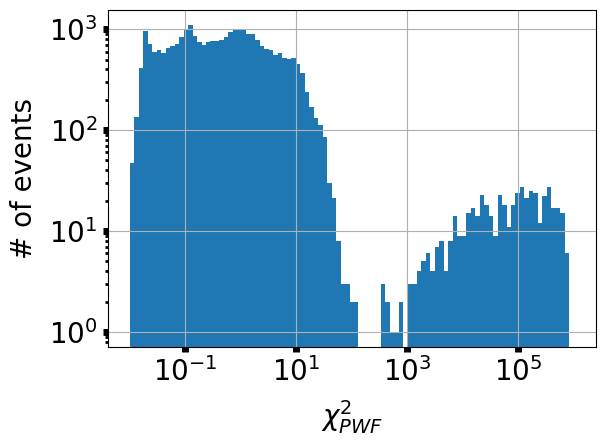

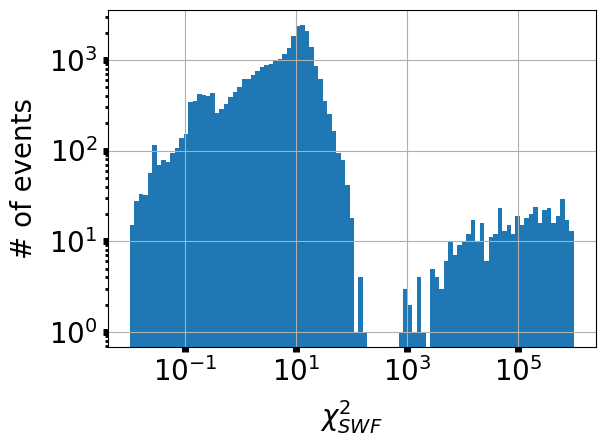

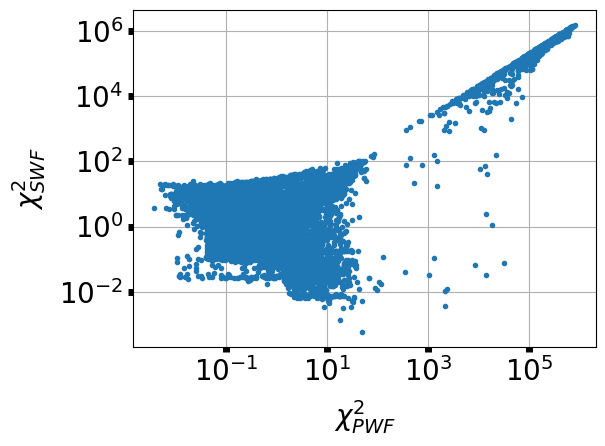

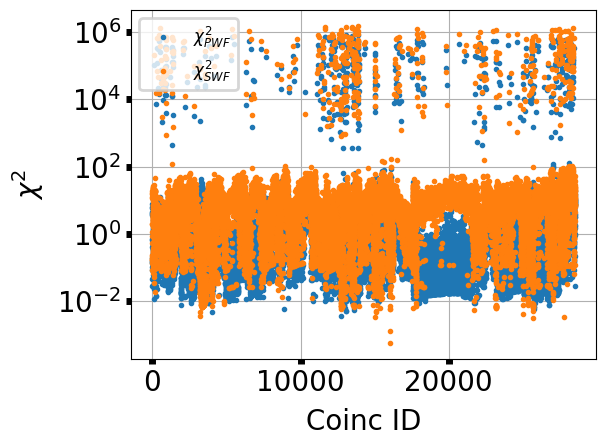

In [19]:
plt.hist(list_chi2, np.logspace(-2, 6, 100));
# plt.axvline(1e7)
plt.ylabel("# of events")
plt.xlabel("$\chi^2_{PWF}$")
plt.grid()
plt.loglog()

plt.figure()
plt.hist(list_chi2_swf, np.logspace(-2, 6, 100));
# plt.axvline(1e7)
plt.ylabel("# of events")
plt.xlabel("$\chi^2_{SWF}$")
plt.grid()
plt.loglog()

plt.figure()
plt.plot(list_chi2,list_chi2_swf,'.')
plt.xlabel("$\chi^2_{PWF}$")
plt.ylabel("$\chi^2_{SWF}$")
plt.grid()
plt.loglog()

plt.figure()
plt.plot(list_chi2,'.',label='$\chi^2_{PWF}$')
plt.plot(list_chi2_swf,'.',label='$\chi^2_{SWF}$')
plt.legend(loc="best")
plt.semilogy()
plt.xlabel("Coinc ID")
plt.ylabel("$\chi^2$")
plt.grid()

## Directions

## Plane recons

Selection ratio 0.9603124719403789


Text(0.5, 0, 'Azimuth [deg]')

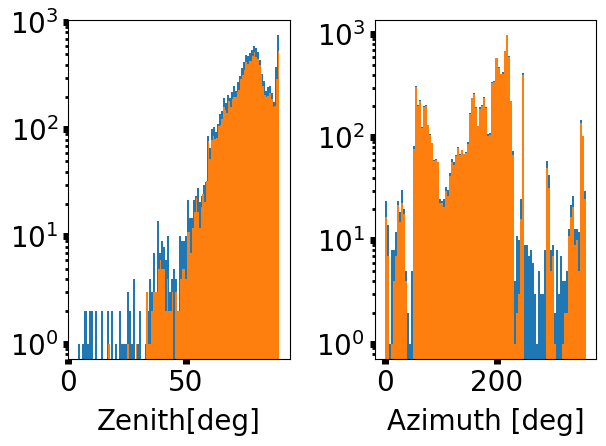

In [6]:
mult = list_rec_plane[:,1].copy()
sel = (list_chi2<100) & (mult>3)
print("Selection ratio",sum(sel)/len(mult))

zenith_wrapped_around_horizon = list_rec_plane[:,2].copy()
zenith_wrapped_around_horizon = 180 - zenith_wrapped_around_horizon
zenith_wrapped_around_horizon[zenith_wrapped_around_horizon > 90] = 90 - (zenith_wrapped_around_horizon[zenith_wrapped_around_horizon > 90] - 90)
azimuth = list_rec_plane[:,4] + 180
azimuth[azimuth > 360] = azimuth[azimuth > 360] - 360


plt.figure()
plt.subplot(1,2,1)
plt.hist(zenith_wrapped_around_horizon,100);
plt.hist(zenith_wrapped_around_horizon[sel],100);
plt.xlabel("Zenith[deg]")
plt.semilogy()
plt.subplot(1,2,2)
plt.hist(azimuth,100);
plt.hist(azimuth[sel],100);
plt.semilogy()
plt.xlabel("Azimuth [deg]")



## Skyplot

36016 123301 11137


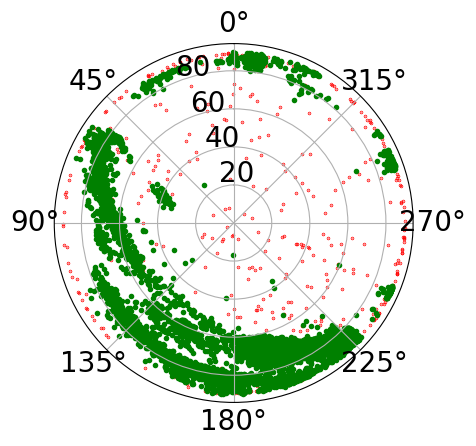

In [7]:
list_event_id_unique, mask_unique, list_n_du = np.unique(list_event_id, return_index=True, return_counts=True)
print(len(list_event_id_unique),len(list_event_id),len(azimuth))
n_min = list_event_t_true[mask_unique] // 1e9 // 60
plt.polar()
#c=(n_min - n_min[0]), cmap="gnuplot"
plt.scatter(azimuth * np.pi / 180, zenith_wrapped_around_horizon, marker='.', ls='-', s=1, c='r')
plt.scatter(azimuth[sel] * np.pi / 180, zenith_wrapped_around_horizon[sel], marker='o', ls='-', s=4, c='g')

plt.gca().set_theta_zero_location('N', offset=0)
#plt.colorbar(location='right', label='Min')

## Spherical recons

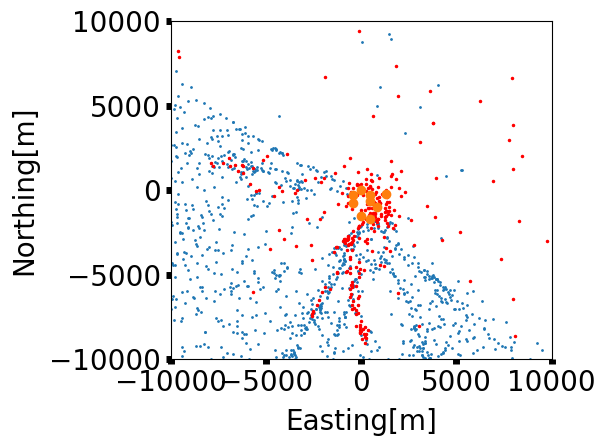

In [8]:
plt.plot(-list_rec_sphere[sel,5], list_rec_sphere[sel,4], marker='.', ls='', markersize=2)
sel_bad_pwf = (list_chi2>100) & (mult>3)
sel_bad_swf = (list_chi2_swf>1000) & (mult>3)
plt.plot(-list_rec_sphere[sel_bad_swf,5], list_rec_sphere[sel_bad_swf,4], color = 'r', marker='.', ls='', markersize=3)
plt.xlabel("Easting[m]")
plt.ylabel("Northing[m]")
dlim = 1e4

plt.xlim(-dlim, dlim)
plt.ylim(-dlim, dlim)
if 1: # Display DU positions
  zdu,ind_dus = np.unique(list_DU_coord[:,3], return_index=True)
  xdu = list_DU_coord[ind_dus,1]
  ydu = list_DU_coord[ind_dus,2]
  plt.plot(-ydu,xdu, 'o')


Text(0.5, 0, 'Distance to source [m]')

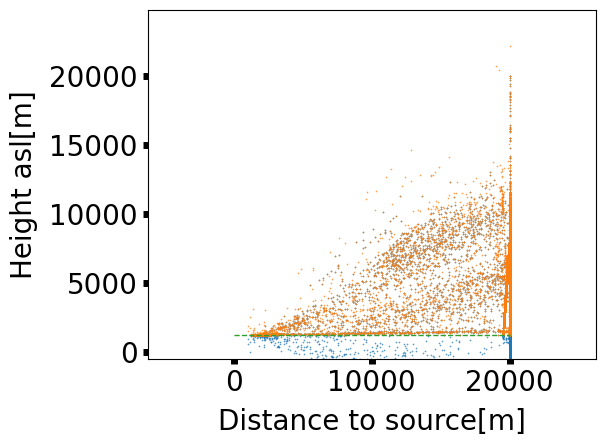

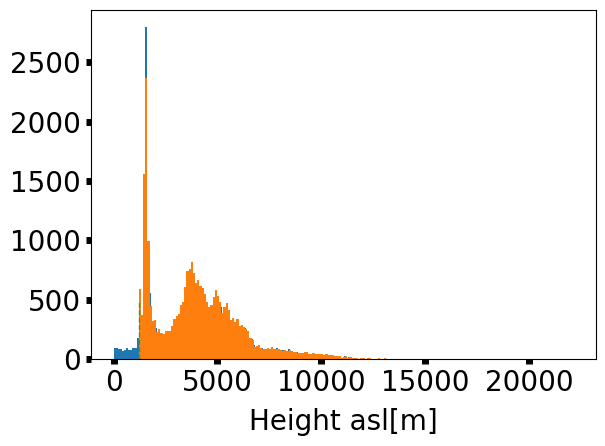

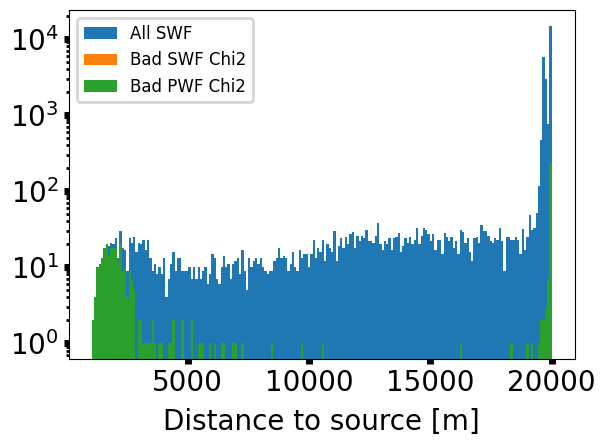

In [23]:
ground_alt = list_rec_sphere[0,9]
z_source = list_rec_sphere[:,6].copy()
z_source[z_source<ground_alt] = 2*ground_alt -  z_source[z_source<ground_alt]
plt.figure()
plt.plot(list_rec_sphere[:,8], list_rec_sphere[:,6], marker='s', ls='', markersize=.2)
plt.plot(list_rec_sphere[:,8], z_source, marker='s', ls='', markersize=.2)
plt.axis("equal")
plt.xlabel("Distance to source[m]")
plt.ylabel("Height asl[m]")
plt.ylim(0,)
plt.plot([0,20000],[ground_alt, ground_alt],'--',linewidth=1)
plt.figure()
plt.hist(np.abs(list_rec_sphere[:,6]),200);
plt.hist(z_source,200);
plt.plot([ground_alt, ground_alt],[0,500],'--',linewidth=1)
plt.xlabel("Height asl[m]")
plt.figure()
plt.hist(np.abs(list_rec_sphere[:,8]),200,label="All SWF");
plt.hist(np.abs(list_rec_sphere[sel_bad_swf,8]),200,label="Bad SWF Chi2");
plt.hist(np.abs(list_rec_sphere[sel_bad_pwf,8]),200,label="Bad PWF Chi2");
plt.legend(loc="best")
plt.semilogy()
plt.xlabel("Distance to source [m]")


## Trigger time distribution

Text(0, 0.5, 'Timestamp[ns]')

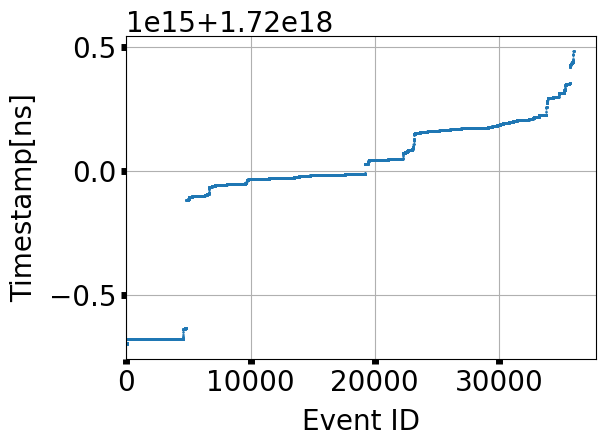

In [9]:
# Get one time for each event

list_event_t_unique = list_event_t_true[mask_unique]
plt.plot(list_event_id_unique, list_event_t_unique, marker='.', ls='', markersize=1)
plt.xlim(0,)
plt.grid(True)
plt.xlabel("Event ID")
plt.ylabel("Timestamp[ns]")

## Negative dt

In [10]:
x = np.diff(list_event_t_true[mask_unique])
print(list_event_id_unique[:-1][(x < 10e3)])
print(x[x < 10e3])

[ 2848. 20334.]
[-41918720. -24681216.]


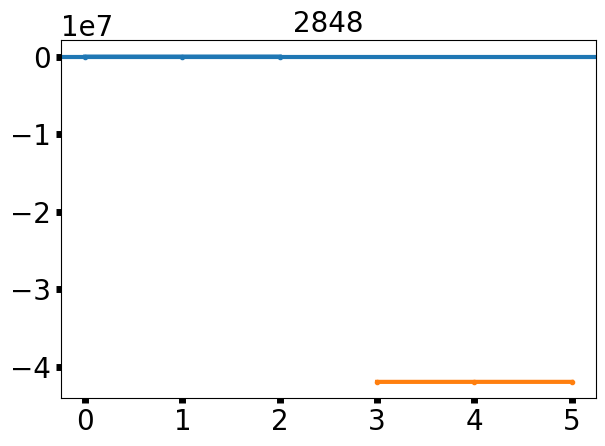

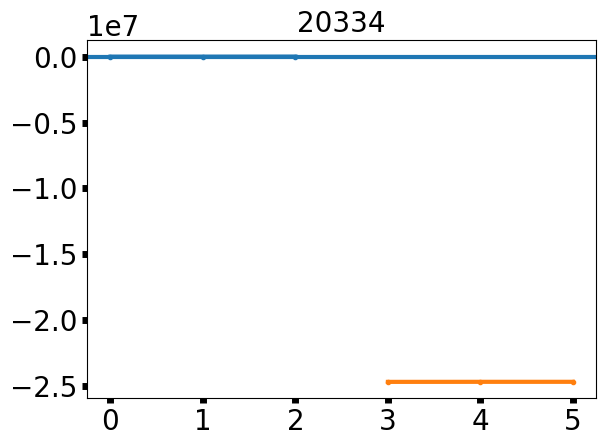

In [11]:
mask_negative_event_id = (list_event_id_unique[:-1][(x < 10e3)])
for e_id in mask_negative_event_id:
    plt.figure()
    plt.title(int(e_id))
    _ = list_event_t_true[list_event_id == e_id]-list_event_t_true[list_event_id == e_id][0]
    __ = list_event_t_true[list_event_id == e_id+1]-list_event_t_true[list_event_id == e_id][0]
    plt.plot(_, marker='.')
    plt.plot(len(_) + np.arange(len(__)), __, marker='.')
    plt.axhline(1e4)
    # plt.axhline(1e4)

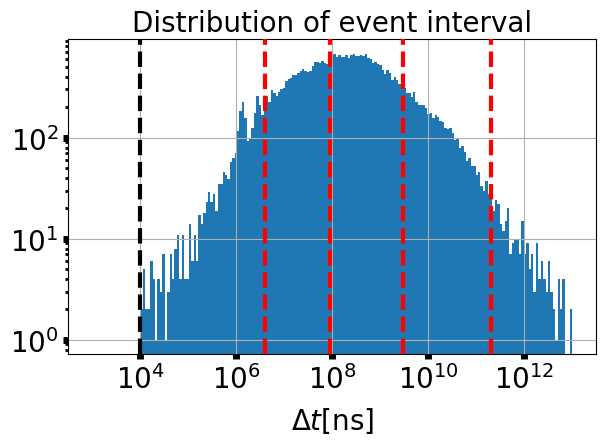

In [12]:
list_t_diff = np.diff(list_event_t_unique)
plt.hist(list_t_diff, np.logspace(3, 13, 200))
plt.axvline(10e3, ls='--', c='k', zorder=100) 
plt.axvline(4e6, ls='--', c='r', zorder=100) # 160Hz
plt.axvline(9e7, ls='--', c='r', zorder=100) # 11Hz
plt.axvline(3e9, ls='--', c='r', zorder=100) # 1Hz
plt.axvline(2e11, ls='--', c='r', zorder=100) # 5E-3 Hz
# plt.axvline(86400e9, ls='--', c='k', zorder=100)
plt.loglog()
plt.xlabel("$\Delta t$[ns]")
plt.title("Distribution of event interval")
plt.grid(True);


## Multiplicity

Nb of events per mult
[3 4 5 6 7 8] [24879  7914  2453   650   117     3]


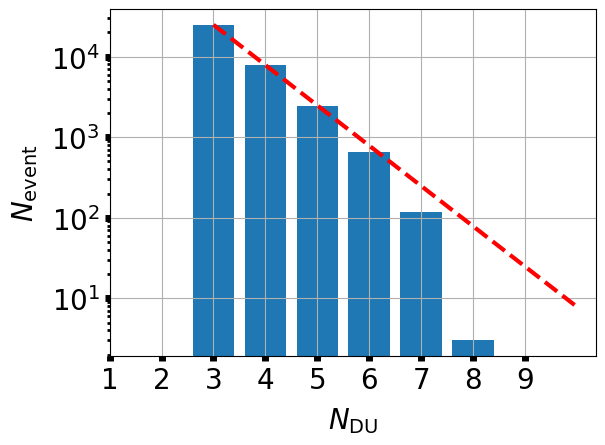

In [13]:
ndu, n = np.unique(list_n_du, return_counts=True)
print("Nb of events per mult")
print(ndu,n)
plt.bar(ndu, n, width=0.8)
plt.plot(np.arange(3,11), n[0] / np.power(10,0.5*(np.arange(3,11)-3)), zorder=100, ls='--', c='r')
plt.grid(True)
plt.semilogy()
plt.xticks(np.arange(1, 10))
plt.xlabel(r"$N_{\rm DU}$")
plt.ylabel(r"$N_{\rm event}$");


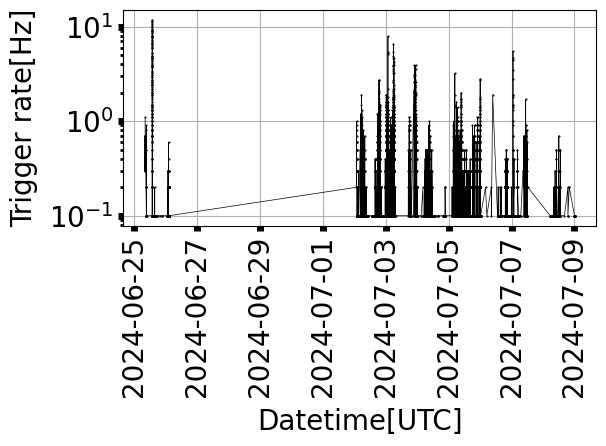

In [14]:
timestamps_ns = list_event_t_unique
timestamps_s = (timestamps_ns // 1e9)
datetime_DU = [datetime.datetime.utcfromtimestamp(int(s)) for s in timestamps_s]
_dt_unique, _dt_n = np.unique(datetime_DU, return_counts=True)
plt.semilogy(_dt_unique, _dt_n/10, marker='.', markersize=1, ls='-', c='k', lw=.5)
plt.xticks(rotation=90)
plt.xlabel("Datetime[UTC]")
plt.ylabel("Trigger rate[Hz]")
plt.grid(True);

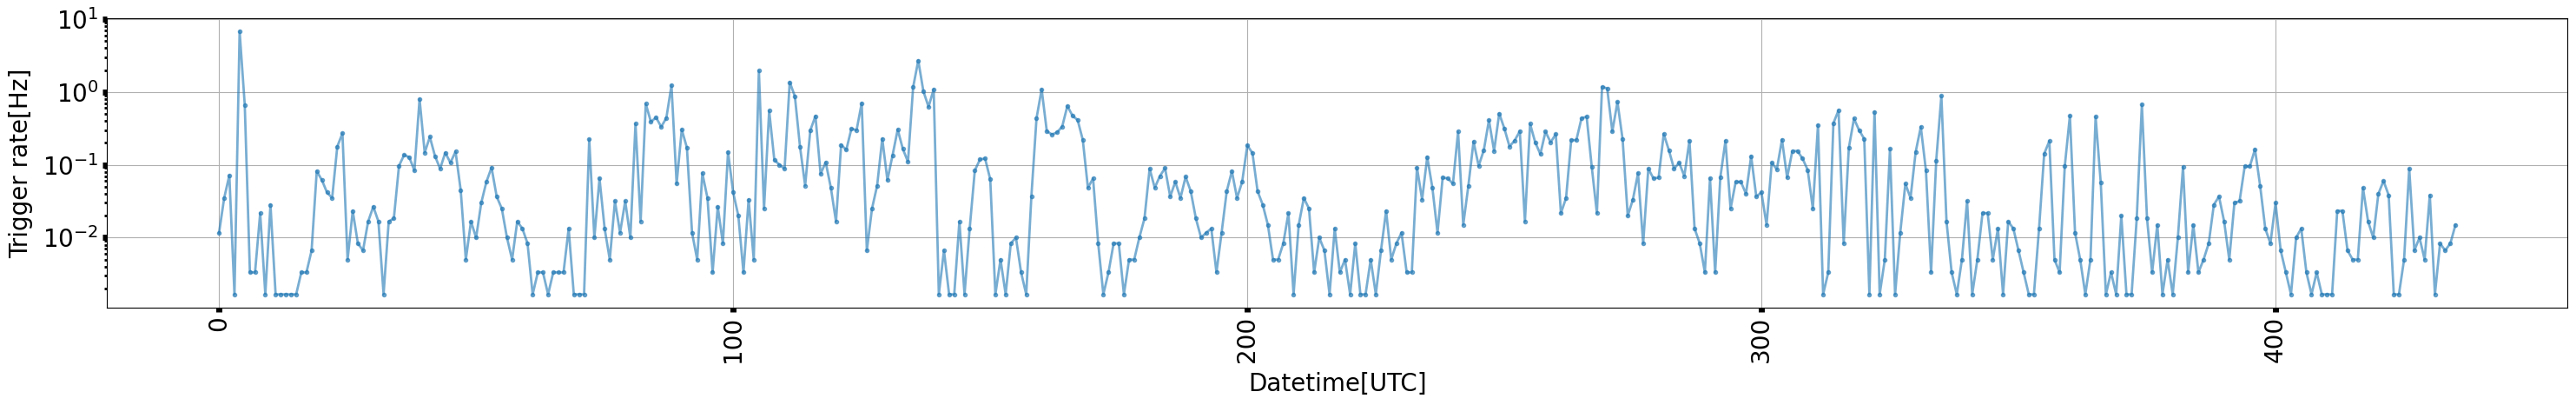

In [15]:
timestamps_min = timestamps_s // 600
t_min_unique, t_min_n = np.unique(timestamps_min, return_counts=True)
datetime_DU_min = [datetime.datetime.utcfromtimestamp(int(s) * 600) for s in t_min_unique]
plt.figure(figsize=(30, 5))
# plt.semilogy(datetime_DU_min, t_min_n / 600, marker='.', markersize=6, ls='-', lw=2, alpha=.6)
plt.semilogy(t_min_n / 600, marker='.', markersize=6, ls='-', lw=2, alpha=.6)
plt.xticks(rotation=90)
plt.xlabel("Datetime[UTC]")
plt.ylabel("Trigger rate[Hz]")
plt.grid(True);

In [ ]:
list_coin_table[list_event_id == [10726]][:,2]

In [ ]:
plt.plot(np.array([10.732032966,
10.732033601,
10.732034075,
10.732035217,
10.732038860,
10.732041829]), marker='.')
plt.axhline(10.732032966 + 10e-6)
plt.plot(list_coin_table[list_event_id == 10725][:,2], marker='.')
plt.plot(list_coin_table[list_event_id == 10726][:,2], marker='.')

In [ ]:
list_coin_table[list_event_id == 8056][:,2] - i

## Trace max

In [33]:
event_id_small_chi2 = list_event_id_unique[list_chi2 < 1e4]
mask_small_chi2_rec = np.zeros(len(list_coin_table), dtype=bool)
for i in event_id_small_chi2:
    mask_small_chi2_rec = mask_small_chi2_rec | (list_event_id == i)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 98260 but corresponding boolean dimension is 28504

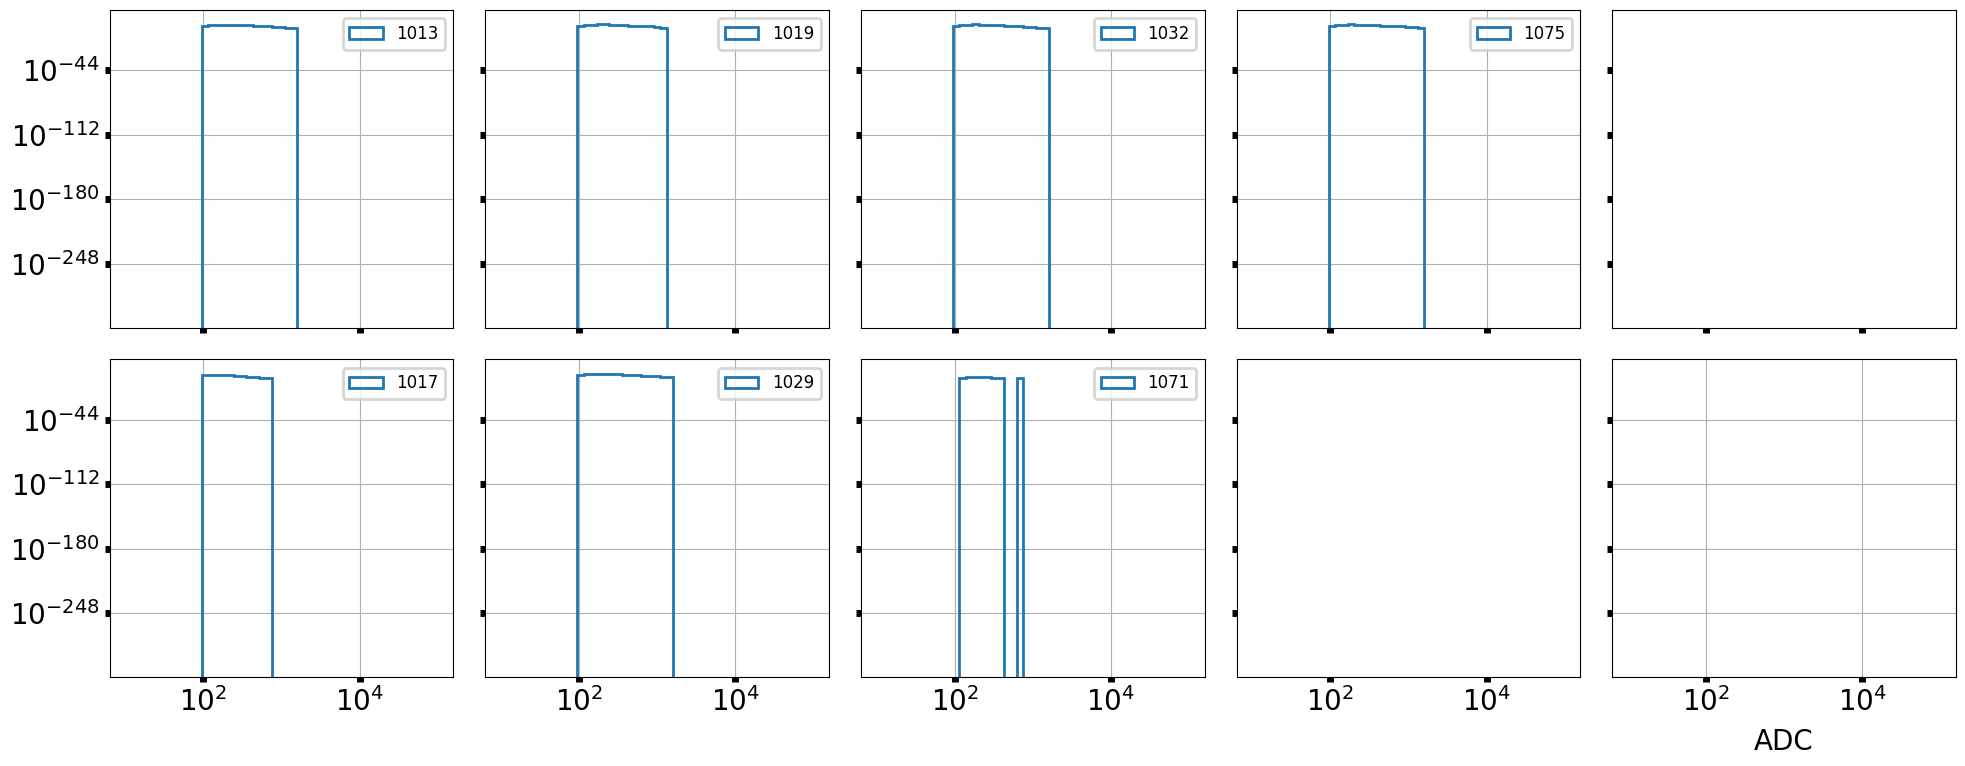

In [34]:
i = 0
fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,
                       figsize=(20, 8))
for du in np.unique(list_DU_id):
    axs[i%2,i//2].hist(list_coin_table[(list_DU_id == du),3], np.logspace(1, 5),
            histtype='step', label=du)
    axs[i%2,i//2].legend()
    axs[i%2,i//2].grid(True)
    i += 1
fig.subplots_adjust(hspace=0, wspace=0)
plt.loglog()
plt.xlabel("ADC")
plt.grid(True);

## When one DU is triggered, it will add some "dead time" to the T3 trigger.

## Event time elapse distribution

In [ ]:
list_event_dt = np.zeros_like(list_event_id_unique, dtype=np.float64)

In [ ]:
list_event_t_true[0]

In [ ]:
for i, id in enumerate(list_event_id_unique):
    event_times = list_event_t_true[list_event_id == id]
    tmax = event_times.max()
    tmin = event_times.min()
    list_event_dt[i] = tmax - tmin

In [ ]:
plt.hist(list_event_dt[list_chi2 < 1e4], np.logspace(2, 5, 31),)
plt.loglog()
plt.xlabel(r"$T_{max}-T_{min}$[ns]")
plt.grid(True)

In [ ]:
plt.hist(list_event_dt, np.logspace(2, 6))
plt.loglog();

## 2D direction distribution

In [16]:
list_index = np.arange(len(azimuth))
# Mask out the flight

Text(0.5, 0, 'Coinc ID')

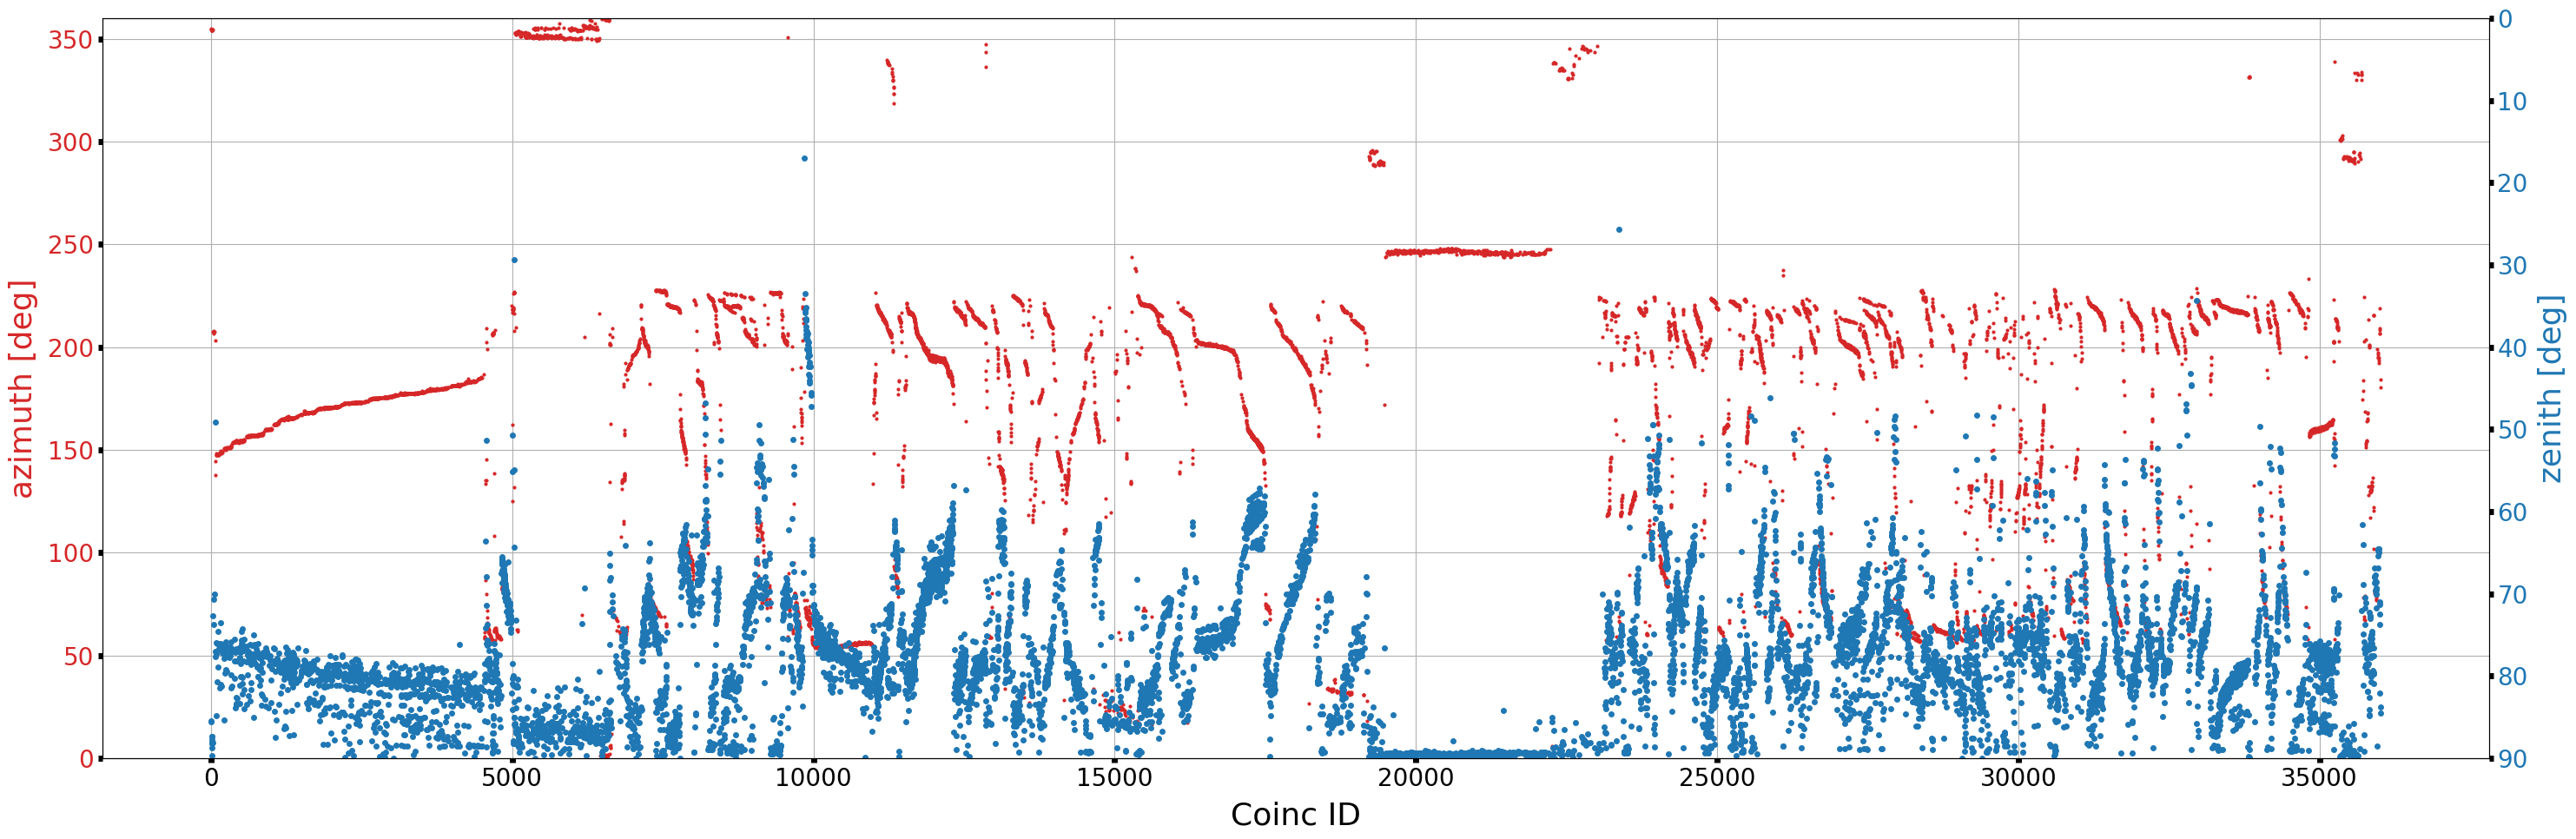

In [17]:
mask_on = (list_chi2 < 40) # & ((zenith_wrapped_around_horizon < 80) & (zenith_wrapped_around_horizon > 60))
seconds_in_one_day = np.array(list_event_t_unique)
fig, ax1 = plt.subplots(figsize=(30,10))
color = 'tab:red'
# ax1.set_xlabel('time (s)')
ax1.set_ylabel('azimuth [deg]', color=color, fontsize=26)
ax1.plot(list_rec_id[sel], azimuth[sel], color=color, ls='', marker='.', markersize=4)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('zenith [deg]', color=color, fontsize=26)  # we already handled the x-label with ax1
ax2.plot(list_rec_id[mask_on], zenith_wrapped_around_horizon[mask_on], color=color, ls='', marker='o', markersize=4)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(90, 0)
ax1.set_ylim(0, 360)
# ax1.set_xlim(datetime_DU[0], datetime_DU[60000])
#ax1.set_xlim(20000,22700)  # Steady source
#ax1.set_xlim(10350,10450)  # Source high in sky
#ax1.set_xlim(600,5000)  # Large stats
#ax1.set_xlim(16700,18000)  # Large stats
#ax1.set_xlim(45600,48000)  # Nice plane track Aug
#ax1.set_xlim(40500,45000)  # Nice plane track Aug
#ax1.set_xlim(61500,71500)  # Nearly steady source Aug


ax1.grid(True)
# ax1.set_xticks(np.arange(0, 65000, 2000))
ax1.set_xlabel("Coinc ID", fontsize=26)

## Steady source

In [18]:
# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

816 events with mult= 4
175 events with mult= 5
34 events with mult= 6
3 events with mult= 7
0 events with mult= 8


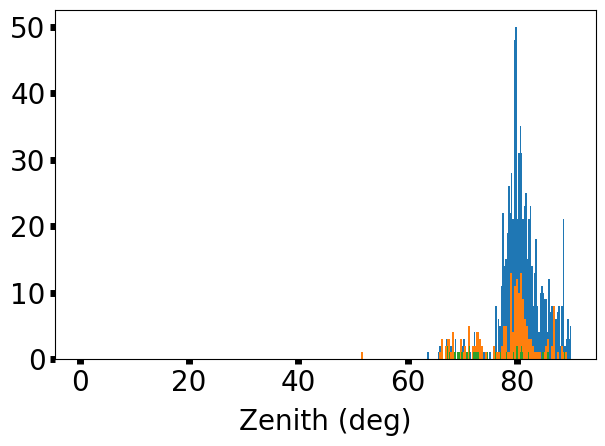

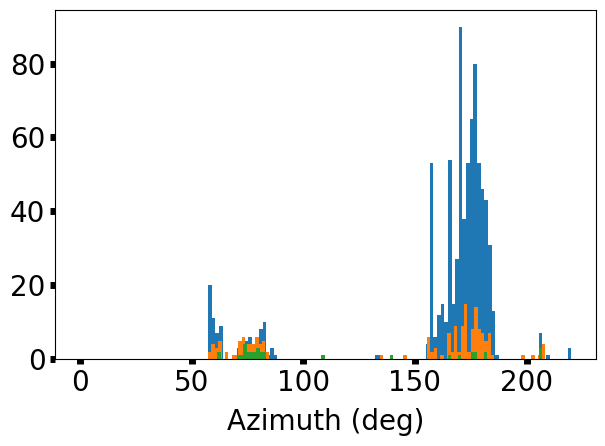

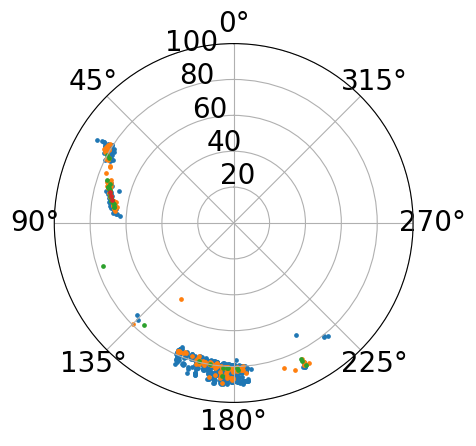

In [101]:
mask_on = (list_chi2 < 100) & (list_rec_id>600) & (list_rec_id<5000)
# (list_rec_id>61500) & (list_rec_id<71500) # Augst
#(list_rec_id>600) & (list_rec_id<5000) # Large stats (plane track?)
#(list_rec_id>10350) & (list_rec_id<10450) # Source high in sky
#(list_rec_id>16700) & (list_rec_id<18000)  # Plane track
#(list_rec_id>20000) & (list_rec_id<22700) & & (azimuth<270) & (azimuth>220) # Steady source
# (list_rec_id>45600) & (list_rec_id<48000) # Beautifull plane track (Aug)
# (list_rec_id>40500) & (list_rec_id<45000) # Beautifull plane track (Aug)

for m in range(int(min(mult)),int(max(mult)+1)):
    mask_in = np.logical_and(mask_on,(mult == m))
    if sum(mask_on)==0:
      continue;
    print(sum(mask_in),"events with mult=",m)
    plt.figure(1)
    plt.hist(zenith_wrapped_around_horizon[mask_in],100);
    plt.xlabel("Zenith (deg)")
    plt.figure(2)
    #mask_az = np.logical_and(mask_in, (azimuth<270))
    h = plt.hist(azimuth[mask_in],100);
    plt.xlabel("Azimuth (deg)")
    #plt.xlim([240,250])
    if 0:
        #sum(mask_on)>3:
        bin_centres = (h[1][:-1] + h[1][1:])/2
        # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
        p0 = [max(h[0]), np.mean(bin_centres), 1.]
        coeff, var_matrix = curve_fit(gauss, bin_centres, h[0], p0=p0)
        h_fit = gauss(bin_centres, *coeff)
        plt.plot(bin_centres, h_fit, label='Fit')
        print(coeff)

    plt.figure(3)        
    plt.polar()
    plt.scatter(azimuth[mask_in] * np.pi / 180, zenith_wrapped_around_horizon[mask_in], marker='o', ls='-', s=2)
    plt.gca().set_theta_zero_location('N', offset=0)
    plt.ylim([0,100])
#plt.colorbar(location='right', label='Min')

Text(0.5, 0, 'Distance to source [m]')

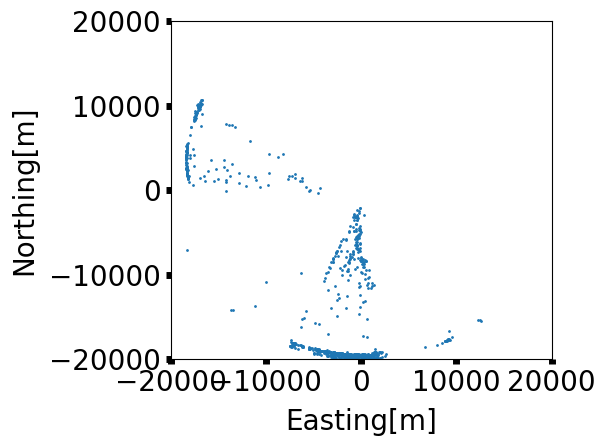

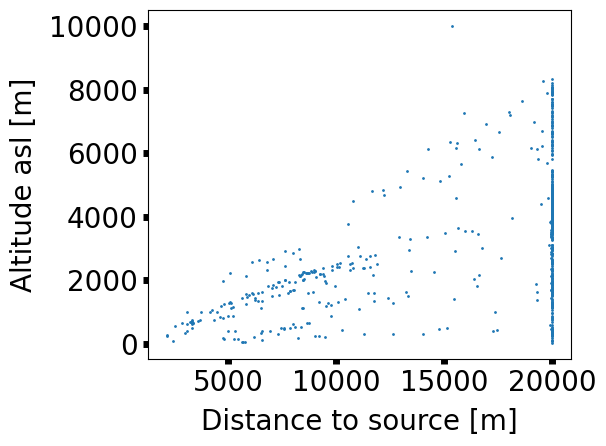

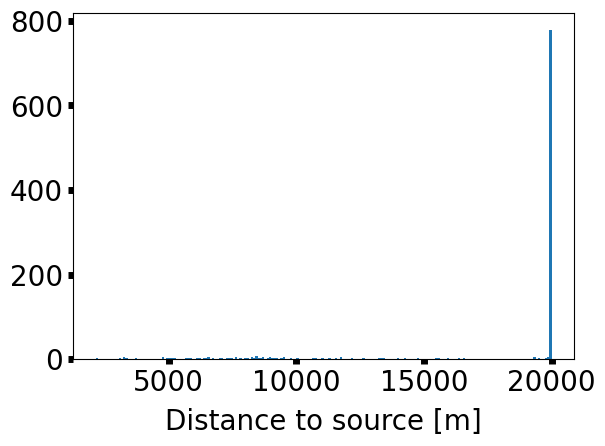

In [102]:
plt.figure()
plt.plot(-list_rec_sphere[mask_on,5], list_rec_sphere[mask_on,4], marker='.', ls='', markersize=2)
# plt.axis("equal")
plt.xlabel("Easting[m]")
plt.ylabel("Northing[m]")
plt.xlim(-2e4, 2e4)
plt.ylim(-2e4, 2e4)

plt.figure()
plt.plot(list_rec_sphere[mask_on,8], abs(list_rec_sphere[mask_on,6]), marker='.', ls='', markersize=2)
plt.xlabel("Distance to source [m]")
plt.ylabel("Altitude asl [m]")

plt.figure()
plt.hist(list_rec_sphere[mask_on,8], 200);
plt.xlabel("Distance to source [m]")
#plt.semilogy()


[1013 1017 1019 1020 1029 1031 1032 1071 1075]
[24.51361868  0.87548638 11.57587549 76.07003891 72.08171206 70.52529183
 41.05058366 69.16342412 58.65758755]


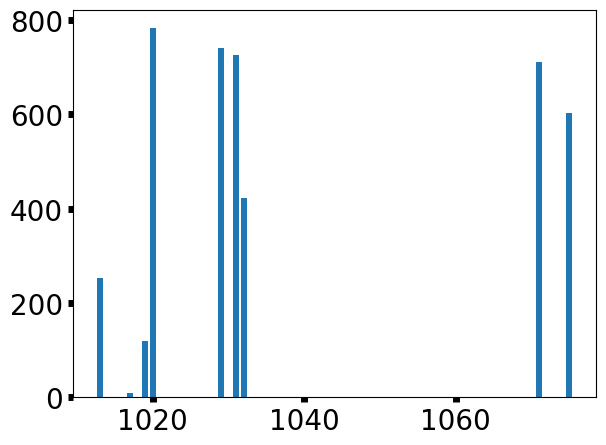

In [103]:
#mask_event, imask_event,_ = np.intersect1d(list_event_id,list_rec_id[mask_on],return_indices=True) # Does not work because interset returns unique values only"
mask_event = np.isin(list_event_id,list_rec_id[mask_on])  # All (duplicated) events 

this_DU_ids = list_DU_id[mask_event]
list_DUs, indu, ncounts = np.unique(this_DU_ids, return_index=True,return_counts=True)
plt.bar(list_DUs, ncounts, width=0.8);
r = np.array(ncounts/sum(mask_on)*100,dtype=float)
print(list_DUs)
print(r)


DU 1013 Mean amp (ADC): 165.37698412698413
DU 1017 Mean amp (ADC): 130.77777777777777
DU 1019 Mean amp (ADC): 159.0
DU 1020 Mean amp (ADC): 218.15217391304347
DU 1029 Mean amp (ADC): 197.69905533063428
DU 1031 Mean amp (ADC): 220.79172413793103
DU 1032 Mean amp (ADC): 232.20616113744074
DU 1071 Mean amp (ADC): 200.70042194092827
DU 1075 Mean amp (ADC): 208.2056384742952


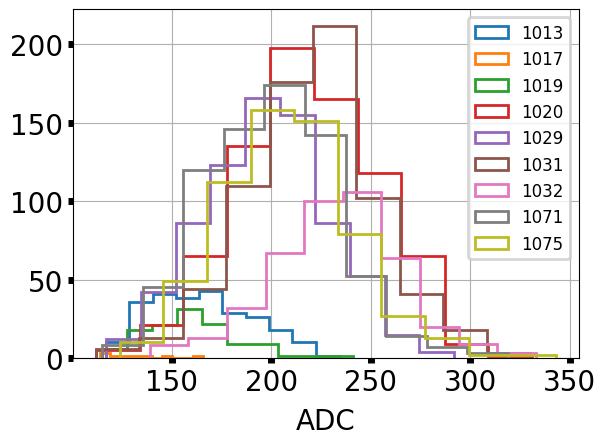

In [104]:
i = 0
#fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True,figsize=(20, 8))
this_amps = list_coin_table[mask_event,3]
mamps = np.zeros((len(list_DUs)))
for i,du in enumerate(list_DUs):
    #axs[i%2,i//2].hist(this_amps[this_DU_ids == du], histtype='step', label=du)
    #axs[i%2,i//2].legend()
    #axs[i%2,i//2].grid(True)
    #i += 1
    plt.hist(this_amps[this_DU_ids == du], histtype='step', label=du)
    print("DU",du,"Mean amp (ADC):",np.mean(this_amps[this_DU_ids == du]))
    mamps[i]=np.mean(this_amps[this_DU_ids == du])
plt.legend()    
fig.subplots_adjust(hspace=0, wspace=0)
#plt.loglog()
plt.xlabel("ADC")
plt.grid(True);

[1013 1017 1019 1020 1029 1031 1032 1071 1075]
[24.51361868  0.87548638 11.57587549 76.07003891 72.08171206 70.52529183
 41.05058366 69.16342412 58.65758755]


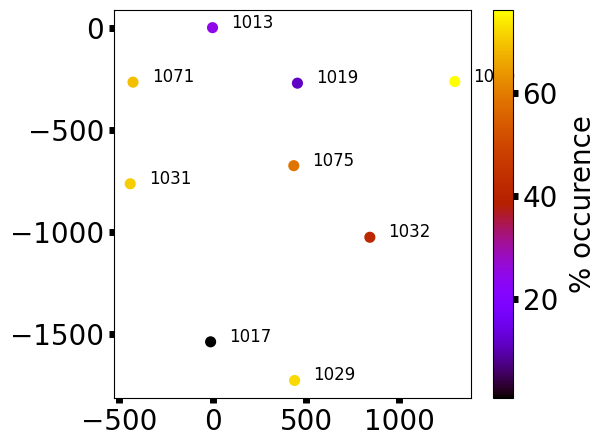

In [105]:
thisDUs = list_DU_coord[mask_event,1:4]
xdu = thisDUs[indu,0]
ydu = thisDUs[indu,1]
zdu = thisDUs[indu,2]
idu = this_DU_ids[indu] 
print(idu)

plt.figure()
print(r)
plt.scatter(-ydu,xdu,c=r, cmap="gnuplot")
plt.colorbar(location='right', label='% occurence')
for i in range(len(idu)):
    plt.text(-ydu[i]+100,xdu[i],idu[i],fontsize=12)
#plt.bar(np.arange(len(list_dus)), ncounts, width=0.8)
#plt.xticks(list_dus)

[ 609.88195817 1994.35443067 1134.63487209 1876.48234851 2313.59185413
 1170.17030074 1932.81985776  673.1193245  1400.99696924] [165.37698413 130.77777778 159.         218.15217391 197.69905533
 220.79172414 232.20616114 200.70042194 208.20563847] [24.51361868  0.87548638 11.57587549 76.07003891 72.08171206 70.52529183
 41.05058366 69.16342412 58.65758755]


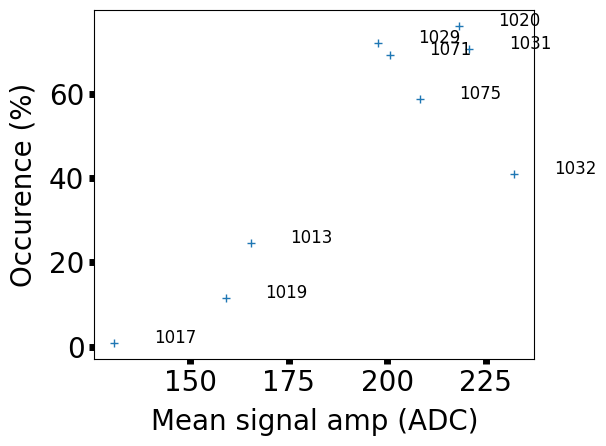

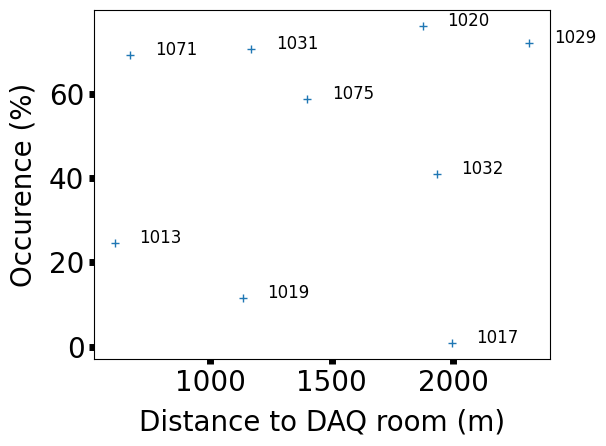

In [106]:
# Correlation of % occurence with amplitude?
plt.plot(mamps,r,'+')
for i in range(len(idu)):
    plt.text(mamps[i]+10,r[i],idu[i],fontsize=12)
plt.xlabel('Mean signal amp (ADC)')
plt.ylabel('Occurence (%)')

# Correlation with distance to DAQ room?
daq_pos = np.array([406,456,1205])
d_daq = np.linalg.norm(np.array([xdu,ydu,zdu]).T-daq_pos,axis=1)
plt.figure()
plt.plot(d_daq,r,'+')
for i in range(len(idu)):
    plt.text(d_daq[i]+100,r[i],idu[i],fontsize=12)
plt.xlabel('Distance to DAQ room (m)')
plt.ylabel('Occurence (%)')

print(d_daq,mamps[:],r)

Text(0, 0.5, 'Occurence (%)')

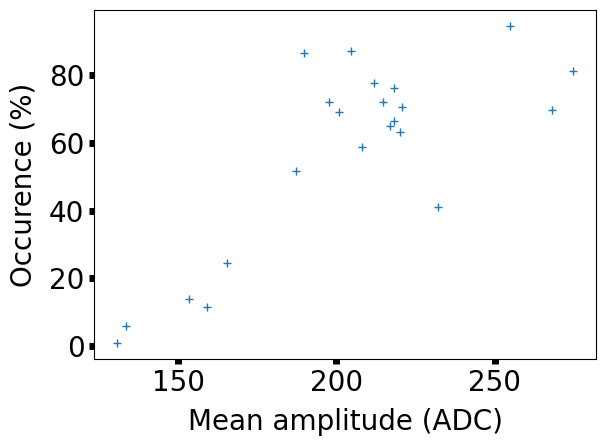

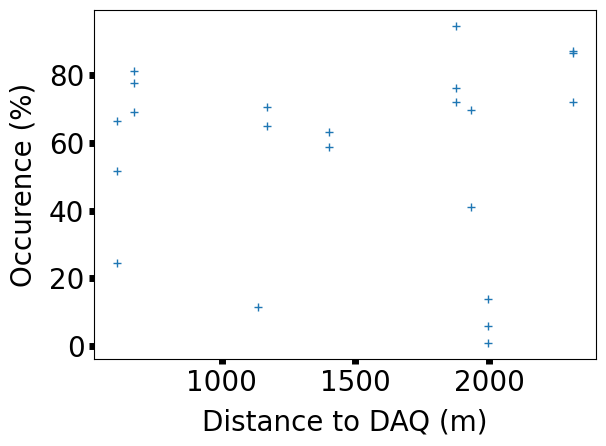

In [114]:
d1 = [ 609.88195817, 1994.35443067, 1876.48234851, 2313.59185413, 1932.81985776,  673.1193245 ]
a1 = [187.1183432,  153.44444444, 254.82524272, 189.75971731, 268.22807018, 274.81132075]
r1 = [51.68195719, 13.76146789, 94.49541284, 86.54434251, 69.72477064, 81.03975535]
d2 = [ 609.88195817, 1994.35443067, 1876.48234851, 2313.59185413, 1170.17030074, 673.1193245,  1400.99696924] 
a2 = [218.2555205,  133.64285714, 214.67346939, 204.67951807, 217.05806452, 211.97843666, 220.17218543]
r2 = [66.45702306,  5.87002096, 71.90775681, 87.00209644, 64.98951782, 77.77777778, 63.31236897]
d3 = [609.88195817, 1994.35443067, 1134.63487209, 1876.48234851, 2313.59185413, 1170.17030074, 1932.81985776,  673.1193245,  1400.99696924] 
a3 = [165.37698413, 130.77777778, 159., 218.15217391, 197.69905533, 220.79172414, 232.20616114, 200.70042194, 208.20563847] 
r3 = [24.51361868,  0.87548638, 11.57587549, 76.07003891, 72.08171206, 70.52529183, 41.05058366, 69.16342412, 58.65758755]

r = np.append(r1,r2)
r = np.append(r,r3)
d = np.append(d1,d2)
d = np.append(d,d3)
a = np.append(a1,a2)
a = np.append(a,a3)

plt.figure()
plt.plot(a,r,'+')
plt.xlabel("Mean amplitude (ADC)")
plt.ylabel("Occurence (%)")
plt.figure()
plt.plot(d,r,'+')
plt.xlabel("Distance to DAQ (m)")
plt.ylabel("Occurence (%)")


## Design a cut to select the outliers (out of track)

### Use slope to remove tracks

In [ ]:
mask_on = (list_chi2 < 1e4) & ((zenith_wrapped_around_horizon < 70) & (zenith_wrapped_around_horizon > 60))
t_start, t_end = list_event_t_true[0], list_event_t_true[-1]
time_bin_edges = np.arange(t_start//1e9, t_end//1e9, 120) # ns divided by 1e9, to second
# t_index = np.digitize(list_event_t_unique[mask_on] // 1e9, time_bin_edges)
mask_track_azimuth = np.ones_like(mask_on)
time_azimuth_variance = np.zeros_like(time_bin_edges[:-1])
list_event_second_unique = list_event_t_unique // 1e9
mask_time = np.zeros_like(azimuth[mask_on], dtype=bool)
for i in range(len(time_azimuth_variance)):
    _mask_time = (list_event_second_unique[mask_on] >= time_bin_edges[i]) & (list_event_second_unique[mask_on] < time_bin_edges[i+1])
    if np.sum(_mask_time) < 2:
        time_azimuth_variance[i] = np.nan
        mask_time = (_mask_time) | (mask_time)
        continue
    phis = azimuth[mask_on][_mask_time]
    phi_max = phis.max()
    phi_min = phis.min()
    phi_var = np.var(phis)
    time_azimuth_variance[i] = np.mean(np.diff(phis))
    # print(np.sum(mask_time))
    # print(phi_max, phi_min, time_azimuth_variance[i])
    if np.abs(time_azimuth_variance[i]) < 1:
        mask_time = (_mask_time) | (mask_time)

In [ ]:
plt.hist(time_azimuth_variance, np.linspace(-5, 5));
# plt.ylim(-5, 5)
plt.semilogy()

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,10))
color = 'tab:red'
# ax1.set_xlabel('time (s)')
ax1.set_ylabel('azimuth [deg]', color=color, fontsize=26)
ax1.plot(list_event_t_unique[mask_on][mask_time], azimuth[mask_on][mask_time], color=color, ls='', marker='.', markersize=6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
# ax2.set_ylabel('zenith [deg]', color=color, fontsize=26)  # we already handled the x-label with ax1
# ax2.plot(list_index[mask_on][mask_time], zenith_wrapped_around_horizon[mask_on][mask_time], color=color, ls='', marker='.', markersize=6)
ax2.semilogy(time_bin_edges[:-1] * 1e9, time_azimuth_variance, color=color, ls='-', marker='.', markersize=20)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(70, 60)
# ax2.set_ylim(0, 40)
ax1.grid(True)
ax1.set_xlabel("Event ID", fontsize=26)
# ax1.set_xlim(4920,5000)
# ax1.set_xlim(5900, 6100)
# ax1.set_ylim(170, 220)
# ax1.set_xlim(time_DU[4000], datetime_DU[6500])

### Exclude events with nearby azimuths in a time window

In [ ]:
# dphi_dt = np.diff(azimuth) / (np.diff(list_event_t_unique) // 1e9)
t_event = 300 # length the of the time window to be counted, sec
d_deg = 4
n_event = 2 # maximum number with close azimuth

d_phi = np.zeros(len(azimuth), dtype=int)
d_theta = np.zeros(len(azimuth), dtype=int)
mask_track = np.zeros(len(azimuth), dtype=bool)
i_event = 0
while i_event < len(list_event_id_unique):
    delta_t = list_event_t_unique - list_event_t_unique[i_event]
    t_mask = np.abs(delta_t) < (t_event * 1e9)  
    delta_phi = azimuth[t_mask] - azimuth[i_event]
    delta_theta = zenith_wrapped_around_horizon[t_mask] - zenith_wrapped_around_horizon[i_event]
    # pf = np.polyfit(np.arange(2*n_event), _phi,1)
    # mask_track[i_event] = np.sum(np.abs(delta_phi) < d_deg)
    d_phi[i_event] = np.sum(np.abs(delta_phi) < d_deg)
    d_phi[i_event] = np.sum(np.abs(delta_theta) < d_deg)
    if np.sum(np.abs(delta_phi) < d_deg) <= n_event:
        mask_track[i_event] = 1
    i_event += 1

In [ ]:
datetime_DU = np.array(datetime_DU)
# mask_on = (list_chi2 < 1e4) & ((zenith_wrapped_around_horizon < 80) & (zenith_wrapped_around_horizon > 60))
mask_on = np.ones_like(mask_track)
list_index = np.arange(len(mask_on))
fig, ax1 = plt.subplots(figsize=(30,10))
color = 'tab:red'
# ax1.set_xlabel('time (s)')
ax1.set_ylabel('azimuth [deg]', color=color, fontsize=26)
ax1.plot(list_index[mask_on & mask_track], azimuth[mask_on & mask_track], color=color, ls='', marker='+', markersize=12, markeredgewidth=2)
ax1.plot(list_index[mask_on & ~mask_track], azimuth[mask_on & ~mask_track], color='g', ls='', marker='.', markersize=2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
# ax2.set_ylabel('zenith [deg]', color=color, fontsize=26)  # we already handled the x-label with ax1
# ax2.plot(list_index[mask_on & mask_track], zenith_wrapped_around_horizon[mask_on & mask_track], color=color, ls='', marker='+', markersize=12)
# ax2.plot(list_index[mask_on & ~mask_track], zenith_wrapped_around_horizon[mask_on & ~mask_track], color=color, ls='', marker='.', markersize=2)

# ax2.plot(list_event_id_unique[mask_on][n_event:-n_event], dphi_dt, color=color, ls='-', marker='.', markersize=6, lw=1, alpha=.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(90, 0)
ax1.set_ylim(0, 360)
ax1.grid(True)
ax1.set_xlabel("Event ID", fontsize=26)
# ax1.set_xlim(datetime_DU[41000], datetime_DU[41600])
# ax1.set_xlim(3000, 3800)

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,10))
color = 'tab:red'
# ax1.set_xlabel('time (s)')
ax1.set_ylabel('azimuth [deg]', color=color, fontsize=26)
# ax1.plot(list_index[mask_on & mask_track], azimuth[mask_on & mask_track], color=color, ls='', marker='+', markersize=12, markeredgewidth=2)
# ax1.plot(list_index[mask_on & ~mask_track], azimuth[mask_on & ~mask_track], color='g', ls='', marker='.', markersize=2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
# ax2.set_ylabel('zenith [deg]', color=color, fontsize=26)  # we already handled the x-label with ax1
ax2.plot(list_index[mask_on & mask_track], zenith_wrapped_around_horizon[mask_on & mask_track], color=color, ls='', marker='+', markersize=12)
ax2.plot(list_index[mask_on & ~mask_track], zenith_wrapped_around_horizon[mask_on & ~mask_track], color='g', ls='', marker='.', markersize=2)

# ax2.plot(list_event_id_unique[mask_on][n_event:-n_event], dphi_dt, color=color, ls='-', marker='.', markersize=6, lw=1, alpha=.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(90, 0)
ax1.set_ylim(0, 360)
ax1.grid(True)
ax1.set_xlabel("Event ID", fontsize=26)
# ax1.set_xlim(datetime_DU[41000], datetime_DU[41600])
# ax1.set_xlim(3000, 3800)

In [ ]:
plt.hist(d_phi, np.linspace(0, 20))
plt.semilogy()

In [ ]:
mask_dphi = dphi_dt < 0.2
fig, ax1 = plt.subplots(figsize=(30,10))
color = 'tab:red'
# ax1.set_xlabel('time (s)')
ax1.set_ylabel('azimuth [deg]', color=color, fontsize=26)
ax1.plot(list_event_id_unique[mask_on][n_event:-n_event][mask_dphi], azimuth[mask_on][n_event:-n_event][mask_dphi], color=color, ls='', marker='.', markersize=6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
# ax2.set_ylabel('zenith [deg]', color=color, fontsize=26)  # we already handled the x-label with ax1
ax2.plot(list_event_id_unique[mask_on][n_event:-n_event][mask_dphi], zenith_wrapped_around_horizon[mask_on][n_event:-n_event][mask_dphi], color=color, ls='', marker='.', markersize=6)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(70, 60)
# ax1.set_ylim(208, 215)
ax1.grid(True)
ax1.set_xlabel("Event ID", fontsize=26)
# ax1.set_xlim(0, 10000)

## Save the mask array to each folder

In [ ]:
# Cuts:
# Chi2 < 1e4 
# 60 < Zenith < 80
# no events < 4deg in 5mins

# Cuts:
# no events < 4deg in 5mins
mask_good_events = mask_on & mask_track

i_start = 0
for i, dir in enumerate(dirlist):
    if not os.path.exists(dir +'/Rec_coinctable.txt'):
      # Empty, skip
      continue
    size = os.path.getsize(dir +'/Rec_coinctable.txt')
    if size == 0:
      # Empty, skip
      continue
    _file_PWF = np.loadtxt(dir +'/Rec_plane_wave_recons.txt').reshape((-1, 9))
    n = len(_file_PWF)
    np.savetxt(dir +'/mask_non_track.txt', mask_good_events[i_start:i_start+n], fmt='%.0f')
    i_start += n

# Check the traces

In [ ]:
list_traces = np.zeros((0, 4, 1024), dtype=np.int16)
for i in dirlist[list_if_file]:
    # print(i)
    _list_traces = np.load(i + "/trace.npz")["arr_0"]
    list_traces = np.append(list_traces, _list_traces, axis=0)

In [ ]:
plt.plot(list_traces[0,0], marker='.')
plt.plot(list_traces[0,1], marker='.')
plt.plot(list_traces[0,2], marker='.')
plt.plot(list_traces[0,3], marker='.');

In [ ]:
list_DU_id_unique = np.unique(list_DU_id)
_ = np.arange(len(list_event_id))
i_start = _[list_event_id == 15000][0]
i_end = _[list_event_id == 20000][-1]
i_mask = (list_event_id >= i_start) & (list_event_id <= i_end)
for du in list_DU_id_unique:
    plt.figure(figsize=(10, 5))
    plt.title(du)
    plt.plot(np.mean(list_traces[(list_DU_id == du) & (i_mask)][0], axis=0), marker='.', lw=2, alpha=.6, label='F', zorder=100)
    plt.plot(np.mean(list_traces[(list_DU_id == du) & (i_mask)][1], axis=0), marker='.', lw=2, alpha=.6, label='X')
    plt.plot(np.mean(list_traces[(list_DU_id == du) & (i_mask)][3], axis=0), marker='.', lw=2, alpha=.6, label='Z')
    plt.legend()
    plt.savefig(f"/Users/xishui/Downloads/trace_{du}.pdf")

## Check the Channel Z fraction

In [ ]:
list_rms_total = np.std(list_traces[:,3,:], axis=1)
list_z_ratio = np.max(list_traces[:,3,:], axis=1) / list_rms_total

In [ ]:
i = np.arange(len(list_rms_total))[list_rms_total < 10][0]

In [ ]:
mask_track_trace = np.zeros_like(list_event_id, dtype='bool')
for i in list_event_id_unique[mask_track]:
    mask_track_trace = mask_track_trace | (list_event_id == i)
    

In [ ]:
plt.plot(np.mean(list_traces[(list_rms_total < 10) & (mask_track_trace),3,:], axis=1), marker='.')

In [ ]:
plt.plot(list_traces[i,3], marker='.')

In [ ]:
plt.hist(list_rms_total[(mask_track_trace)], np.logspace(-1,4))
plt.loglog();

In [ ]:
plt.hist(list_z_ratio[(mask_track_trace)], np.logspace(-1, 2, 200))
plt.loglog()
plt.xlabel(r"$Z_{max}/RMS_{Z}$");

# Only save the non-track events

In [ ]:
index_arr = np.arange(len(mask_good_events))

In [ ]:
# Cuts:
# no events < 4deg in 5mins
mask_good_events = mask_on & mask_track
mask_good_events_by_DU = np.array([if i in _index_arr[mask_good_events]] for i in _file_coinc[:,1]])

file_duid_total = np.zeros((np.sum(mask_good_events), 4),
                           dtype=[('DU', int), ('Second0', 'int'), ('Nanosecond0', 'int'), ("Entry", "int")])
file_coin_total = np.zeros((np.sum(mask_good_events), 4), dtype=[('Linenumber', int), ('EventID', 'int'), ('Relative_second', np.float64), ("ADC_Max", int)])
file_trace_total = np.zeros((np.sum(mask_good_events), 4, 1024), dtype=int)


In [ ]:
good_ids = index_arr[mask_good_events]

In [ ]:
if_valide = np.array([True if i in good_ids else False for i in list_event_id ])

In [ ]:
valide_DU_id = list_DU_id[if_valide]

In [ ]:
list_coin_table_valide = list_coin_table[if_valide].copy()
list_coin_table_valide[:,0] = np.arange(len(list_coin_table_valide))
list_coin_table_valide[:,1] = list_event_id[if_valide]

list_DU_coord_valide = list_DU_coord[if_valide].copy()
list_DU_coord_valide[:,0] = np.arange(len(list_coin_table_valide))

In [ ]:
# Save
np.savez("GP13_UD_Offline_events", coinctable=list_coin_table_valide,
        du_id=valide_DU_id, trace=list_traces[if_valide],
         du_coord=list_DU_coord_valide)

In [ ]:
len(np.unique(list_coin_table_valide[:,1]))

In [ ]:
list_coin_table_valide[:5,1]

In [ ]:
list_coin_table_valide[:3]

In [ ]:
valide_DU_id[:3]